# Database Analysis Code

Contains code to analyse the training set dataset used for the MPScore. This includes: identifying the functional groups present in the training database; an analysis of the consistency between chemists and the correlation between the SAScore, SCScore and chemist data.

In [55]:
from sqlalchemy import create_engine
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
import json
from collections import defaultdict
from rdkit.Chem import AllChem as rdkit
import csv
from rdkit.Chem.MolStandardize import standardize_smiles
import seaborn as sns
from rdkit import Chem
from matplotlib import pyplot as plt
import itertools as it
pd.set_option("display.max_rows", 10)

In [105]:
# Analysing the functional groups in the training dataset
def find_functional_groups():
    training_db = "../data/training_mols.json"
    with open(training_db, "r") as f:
        training_db = json.load(f)
    fg_smarts = {
        'amine': ('[N]([H])[H]'),
        'aldehyde': ('[C](=[O])[H]'),
        'carboxylic_acid': ('[C](=[O])-[O][H]'),
        'fluorine': ('[F]'),
        'chlorine': ('[Cl]'),
        'bromine': ('[Br]'),
        'iodine': ('[I]'),
        'astatine': ('[As]'),
        'alcohol': ('[C]([H])([H])-[O][H]'),
        'alcohol2': ('[O][H]'),
        'alkene': ('[C]=[C]([H])[H]'),
        'alkyne': ('[C]#[C][H]'),
        'thiol': ('[S][H]'),
        'amide': ('[C](=[O])[N]([H])[H]'),
        'boronic_acid': ('[B]([O][H])[O][H]'),
        'xenon': ('[Xe]'),
        'methyl': ('[C]([H])([H])[H]'),
        'ethyl': ('[C]([H])([H])[C]([H])([H])[H]'),
        'propyl': ('[C]([H])([H])[C]([H])([H])[C]([H])([H])[H]'),
    }
    fg_counter = defaultdict(int)
    removed = []
    for inchi in tqdm(training_db):
        mol = Chem.AddHs(Chem.MolFromInchi(inchi))
        for fg in fg_smarts:
            fg_smart = fg_smarts[fg]
            counter = 0
            substruct = Chem.MolFromSmarts(fg_smart)
            matches = mol.GetSubstructMatches(substruct)
            counter += len(matches)
            # Ignore molecules if functional groups are less than two.
            if counter >= 2:
                fg_counter[f'{fg}_{counter}'] += 1
                removed.append(inchi)
                break
    sorted_db_funcs = sorted(fg_counter.items(), key=lambda x: x[0])
    db_funcs = pd.DataFrame(sorted_db_funcs)
    return db_funcs
db_fgs = find_functional_groups()
print(db_fgs)

  0%|          | 0/14859 [00:00<?, ?it/s]

RDKit WARNING: [12:05:02] Cannot assign bond directions!
RDKit WARNING: [12:05:02] Cannot assign bond directions!
RDKit WARNING: [12:05:02] Cannot assign bond directions!
RDKit WARNING: [12:05:02] Cannot assign bond directions!
RDKit WARNING: [12:05:02] Cannot assign bond directions!
RDKit WARNING: [12:05:02] Cannot assign bond directions!
RDKit WARNING: [12:05:04] Cannot assign bond directions!
RDKit WARNING: [12:05:04] Cannot assign bond directions!
RDKit WARNING: [12:05:04] Cannot assign bond directions!
RDKit WARNING: [12:05:04] Cannot assign bond directions!
RDKit WARNING: [12:05:04] Cannot assign bond directions!
RDKit WARNING: [12:05:04] Cannot assign bond directions!
RDKit WARNING: [12:05:04] Cannot assign bond directions!
RDKit WARNING: [12:05:04] Cannot assign bond directions!
RDKit WARNING: [12:05:04] Cannot assign bond directions!
RDKit WARNING: [12:05:04] Cannot assign bond directions!
RDKit WARNING: [12:05:05] Cannot assign bond directions!
RDKit WARNING: [12:05:05] Canno

             0     1
0   alcohol2_2    19
1   alcohol2_3     2
2   alcohol2_4     2
3    alcohol_2  1030
4    alcohol_3   137
..         ...   ...
46    methyl_2    59
47    methyl_3    30
48    methyl_4     6
49    methyl_5     2
50     thiol_2    24

[51 rows x 2 columns]


RDKit WARNING: [12:05:09] Cannot assign bond directions!


In [106]:
# Analysing chemist data
def load_chemist_data():
    p1 = main_dir.joinpath("data/chemist_data/opinions_becky.json")
    p2 = main_dir.joinpath("data/chemist_data/opinions_mebriggs.json")
    p3 = main_dir.joinpath("data/chemist_data/filip.csv")
    # Finding disagreements in training data
    with open(str(p1)) as f:
        rg = json.load(f)
    with open(str(p2)) as f:
        mb = json.load(f)
    with open(str(p3)) as f:
        reader = csv.reader(f, delimiter='\t')
        fs = {rdkit.MolToInchi(rdkit.MolFromSmiles(smi)): sco for sco, smi in reader}
    def parse_training(training_dict):
        d = defaultdict(list)
        for inchi in training_dict:
            # Convert and standardise SMILES string.
            d['smiles'].append(standardize_smiles(rdkit.MolToSmiles(rdkit.MolFromInchi(inchi))))
            d['chemist_score'].append(int(training_dict[inchi]))
        return pd.DataFrame(d)
    fs = parse_training(fs)
    rg = parse_training(rg)
    mb = parse_training(mb)
    # Molecules scored by all three chemists
    all_three = rg.rename(columns={'chemist_score': 'RLG'}).merge(fs.rename(columns={'chemist_score': 'FS'}), on='smiles').merge(mb.rename(columns={'chemist_score': 'MB'}), on='smiles')
    # Molecules scored by two chemists
    two = pd.concat([rg.merge(fs, on='smiles'), fs.merge(mb, on='smiles'), rg.merge(mb, on='smiles')])
    mols = [] 
    rows = []
    count = 0
    for i, r in all_three.iterrows():
        if (int(r.RLG) != int(r.FS)) or (int(r.FS) != int(r.MB)):
            count+=1
            rows.append(r)
            mols.append(r.smiles)
    print(f"There were {len(all_three)} molecules labelled by all three chemists")
    print(f"{count} molecules were labelled the same by all three chemists and {len(all_three)-count} were labelled differently.")
    count = 0
    column_names = ['RLG', 'FS', 'MB']
    df1 = rg.merge(fs, on='smiles')
    df1[~df1['smiles'].isin(all_three['smiles'])]
    df2 = rg.merge(mb, on='smiles')
    df2[~df2['smiles'].isin(all_three['smiles'])]
    df3 = fs.merge(mb, on='smiles')
    df3[~df3['smiles'].isin(all_three['smiles'])]
    for r in pd.concat([df1, df2, df3]).itertuples():
        if (int(r.chemist_score_x) == int(r.chemist_score_y)):
            count+=1
    print(f'There were {count} molecules labelled the same out of those scored by two chemists.')
    print(f'There were {len(pd.concat([df1, df2, df3])) - count} molecules labelled differently out of those scored by two chemists.')
    print(f'RLG labelled {sum(rg.chemist_score)} easy-to-synthesise and {len(rg)-sum(rg.chemist_score)} difficult-to-synthesise')
    print(f'FS labelled {sum(fs.chemist_score)} easy-to-synthesise and {len(fs)-sum(fs.chemist_score)} difficult-to-synthesise')
    print(f'MB labelled {sum(mb.chemist_score)} easy-to-synthesise and {len(mb)-sum(mb.chemist_score)} difficult-to-synthesise')
    return 
data = load_chemist_data()

RDKit WARNING: [12:05:31] WARNING: Omitted undefined stereo
RDKit WARNING: [12:05:31] WARNING: Omitted undefined stereo
RDKit WARNING: [12:05:31] WARNING: Omitted undefined stereo
RDKit WARNING: [12:05:31] WARNING: Omitted undefined stereo
RDKit WARNING: [12:05:31] WARNING: Omitted undefined stereo
RDKit WARNING: [12:05:31] WARNING: Omitted undefined stereo
RDKit WARNING: [12:05:31] WARNING: Omitted undefined stereo
RDKit WARNING: [12:05:31] WARNING: Omitted undefined stereo
RDKit WARNING: [12:05:31] WARNING: Omitted undefined stereo
RDKit WARNING: [12:05:31] WARNING: Omitted undefined stereo
RDKit WARNING: [12:05:31] WARNING: Omitted undefined stereo
RDKit WARNING: [12:05:31] WARNING: Omitted undefined stereo
RDKit WARNING: [12:05:31] WARNING: Omitted undefined stereo
RDKit WARNING: [12:05:31] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [12:05:31]   BondStereo set to STEREONONE and single bond directions set to NONE.
RDKit WARNING: [12:05:31] WARNI

There were 42 molecules labelled by all three chemists
11 molecules were labelled the same by all three chemists and 31 were labelled differently.
There were 1179 molecules labelled the same out of those scored by two chemists.
There were 446 molecules labelled differently out of those scored by two chemists.
RLG labelled 1109 easy-to-synthesise and 8891 difficult-to-synthesise
FS labelled 667 easy-to-synthesise and 1191 difficult-to-synthesise
MB labelled 232 easy-to-synthesise and 463 difficult-to-synthesise


The correlation between the SAScore and SCScore is: 0.12156426384760034


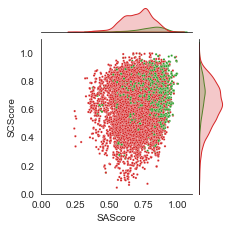

In [185]:
def plot_figure4():
    df_training = pd.read_csv(main_dir.joinpath('data/chemist_data/training_data_with_sascores.csv'), names=['smiles', 'sas', 'scs', 'chemist_score', 'sas_norm', 'scs_norm'])
    # Scaling scores between 0 and 1
    df_training['sas_norm'] = [(val-10)/(1-10) for val in df_training['sas'].to_list()]
    df_training['scs_norm'] = [(val-5)/(1-5) for val in df_training['scs'].to_list()]
    # Plotting SA-SCScore correlations.
    print(f"The correlation between the SAScore and SCScore is: {df_training['scs'].corr(df_training['sas'])}")
    sns.set_style('white')
    palette = sns.color_palette() 
    # Green = palette[2] = Easy-to-synthesise
    # Red = palette[3] = Difficult-to-synthesise 
    colors = [palette[3]] + [palette[2]]
    g = sns.jointplot(
        data=df_training,
        x='sas_norm',
        y='scs_norm',
        hue='chemist_score',
        palette=colors,
        space=0.3,
        xlim=[0,1.1],
        ylim=[0,1.1],
        s=5,
        linewidth=0.2,
        height= 3.3
    )
    g.set_axis_labels(xlabel='SAScore', ylabel='SCScore', fontsize='medium')
    g.ax_joint.legend_.remove()
    g.ax_joint.tick_params('both', labelsize='medium')
    return g
plot_figure4()

# POC Precursor Screening

In this section, we filter for easy-to-synthesise molecules using our developed MPScore, the SAScore and SCScore.
We show the distriubtions of synthetic difficulty scores for each precursor combination in our precursor database.

/Users/stevenbennett/anaconda3/envs/saprojectclean/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.22.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/stevenbennett/anaconda3/envs/saprojectclean/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.22.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


  0%|          | 0/7288 [00:00<?, ?it/s]

0it [00:00, ?it/s]

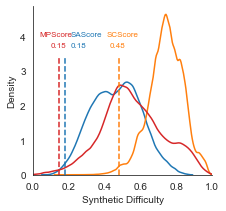

In [189]:
def plot_figure6():
    # Loading Reaxys data
    import sys
    sys.path.append(str(main_dir))
    from scripts.mpscore import MPScore
    con = create_engine(
        f"sqlite:///{str(main_dir.joinpath('data/Reaxys_DB_Scored_AddHs.db'))}"
    )
    df_reaxys = pd.read_sql(sql="synthetic_accesibility", con=con)
    # Perform standardization on all molecules in Reaxys.
    model = MPScore()
    model.restore()
    df_reaxys['standardized_smiles'] = [standardize_smiles(smi) for smi in df_reaxys['smiles']]
    df_reaxys['rfmodel_fulldataset'] = [model.predict_proba(rdkit.AddHs(rdkit.MolFromSmiles(x))) for x in tqdm(df_reaxys['standardized_smiles'])]
    bb_gen = it.product(
        (r[1] for r in df_reaxys[df_reaxys["func_group"] == "primary amine"].iterrows()),
        (r[1] for r in df_reaxys[df_reaxys["func_group"] == "aldehyde"].iterrows()),
    )
    combinations = defaultdict(list)
    smiles_cache = {}
    for bbs in tqdm(bb_gen):
        _bb = smiles_cache.get(bbs[0]['smiles'], None)
        amine_smiles =  _bb if _bb else standardize_smiles(bbs[0]['smiles'])
        _bb = amine_smiles
        smiles_cache[bbs[0]['smiles']] = _bb
        _bb = smiles_cache.get(bbs[1]['smiles'], None)
        aldehyde_smiles =  _bb if _bb else standardize_smiles(bbs[1]['smiles'])
        _bb = aldehyde_smiles
        smiles_cache[bbs[1]['smiles']] = _bb
        combinations["bb"].append(
            aldehyde_smiles + ',' + amine_smiles
        )
        combinations["sascore_combination"].append(sum(r["sascore"] for r in bbs)/2)
        combinations["scscore_combination"].append(sum(r["scscore"] for r in bbs)/2)
        combinations["rfmodel_fulldataset_combination"].append(sum(r["rfmodel_fulldataset"] for r in bbs)/2)
    df_combinations = pd.DataFrame(combinations)
    sns.set_style('white')
    palette = sns.color_palette()
    fig, ax = plt.subplots(1, figsize=(6.43420506434205/2, 3.1))
    sns.kdeplot(data=df_combinations, x='sascore_combination', ax=ax, color=palette[0])
    sns.kdeplot(data=df_combinations, x='scscore_combination', ax=ax, color=palette[1])
    sns.kdeplot(data=df_combinations, x='rfmodel_fulldataset_combination', ax=ax, color=palette[3])
    sns.despine()
    ax.set_xlabel('Synthetic Difficulty', fontsize='medium')
    ax.set_ylabel('Density', fontsize='medium')
    ax.axvline(df_combinations['sascore_combination'].quantile(0.01), 0, 0.7, color=palette[0], linestyle ="--")
    ax.text(df_combinations['sascore_combination'].quantile(0.01)+0.033, 3.7, f"{round(df_combinations['sascore_combination'].quantile(0.01), 2)}", color=palette[0], fontsize=8)
    ax.text(df_combinations['sascore_combination'].quantile(0.01)+0.03, 4, "SAScore", color=palette[0], fontsize=8)

    # ax.arrow(df_combinations['sascore_combination'].quantile(0.01), 4.45, -df_combinations['sascore_combination'].quantile(0.01), 0, color=palette[0], shape='full', head_width=0.25, head_length=0.03, length_includes_head=True)
    ax.axvline(df_combinations['scscore_combination'].quantile(0.01), 0, 0.7, color=palette[1], linestyle ="--")
    ax.text(df_combinations['scscore_combination'].quantile(0.01)-0.05, 3.7, f"{round(df_combinations['scscore_combination'].quantile(0.01), 2)}", color=palette[1], fontsize=8)
    ax.text(df_combinations['scscore_combination'].quantile(0.01)-0.07, 4, "SCScore", color=palette[1], fontsize=8)

    # ax.arrow(1, 4.75, -df_combinations['scscore_combination'].quantile(0.01), 0, color=palette[1], shape='full', head_width=0.25, head_length=0.03, length_includes_head=True)
    ax.axvline(df_combinations['rfmodel_fulldataset_combination'].quantile(0.01), 0, 0.7, color=palette[3], linestyle ="--")
    ax.text(df_combinations['rfmodel_fulldataset_combination'].quantile(0.01)-0.05, 3.7, f"{round(df_combinations['rfmodel_fulldataset_combination'].quantile(0.01), 2)}", color=palette[3], fontsize=8)
    ax.text(df_combinations['rfmodel_fulldataset_combination'].quantile(0.01)-0.11, 4, "MPScore", color=palette[3], fontsize=8)
    ax.tick_params(labelsize='medium')
    # ax.arrow(df_combinations['rfmodel_fulldataset_combination'].quantile(0.01), 4.15, -df_combinations['rfmodel_fulldataset_combination'].quantile(0.01), 0, color=palette[3], shape='full', head_width=0.25, head_length=0.03, length_includes_head=True)
    ax.set_xlim(0, 1.0)
    return fig, ax
df_combinations = plot_figure6()

In [195]:
def get_precursor_combinations():
    # Loading Reaxys data
    import sys
    sys.path.append(str(main_dir))
    from scripts.mpscore import MPScore
    con = create_engine(
        f"sqlite:///{str(main_dir.joinpath('data/Reaxys_DB_Scored_AddHs.db'))}"
    )
    df_reaxys = pd.read_sql(sql="synthetic_accesibility", con=con)
    # Perform standardization on all molecules in Reaxys.
    model = MPScore()
    model.restore('/Users/stevenbennett/PhD/Main_Projects/Synthetic_Accessibility_Project/Clean/models/RFModel_FullDatasetTrained.joblib')
    df_reaxys['standardized_smiles'] = [standardize_smiles(smi) for smi in df_reaxys['smiles']]
    df_reaxys['rfmodel_fulldataset'] = [model.predict_proba(rdkit.AddHs(rdkit.MolFromSmiles(x))) for x in tqdm(df_reaxys['standardized_smiles'])]
    bb_gen = it.product(
        (r[1] for r in df_reaxys[df_reaxys["func_group"] == "primary amine"].iterrows()),
        (r[1] for r in df_reaxys[df_reaxys["func_group"] == "aldehyde"].iterrows()),
    )
    combinations = defaultdict(list)
    smiles_cache = {}
    for bbs in tqdm(bb_gen):
        _bb = smiles_cache.get(bbs[0]['smiles'], None)
        amine_smiles =  _bb if _bb else standardize_smiles(bbs[0]['smiles'])
        _bb = amine_smiles
        smiles_cache[bbs[0]['smiles']] = _bb
        _bb = smiles_cache.get(bbs[1]['smiles'], None)
        aldehyde_smiles =  _bb if _bb else standardize_smiles(bbs[1]['smiles'])
        _bb = aldehyde_smiles
        smiles_cache[bbs[1]['smiles']] = _bb
        combinations["bb"].append(
            aldehyde_smiles + ',' + amine_smiles
        )
        combinations["sascore_combination"].append(sum(r["sascore"] for r in bbs)/2)
        combinations["scscore_combination"].append(sum(r["scscore"] for r in bbs)/2)
        combinations["rfmodel_fulldataset_combination"].append(sum(r["rfmodel_fulldataset"] for r in bbs)/2)
        combinations["rfmodel_combination"].append(sum(r["rfmodel"] for r in bbs)/2)
    return pd.DataFrame(combinations)
df_combinations = get_precursor_combinations()

/Users/stevenbennett/anaconda3/envs/saprojectclean/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.22.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/stevenbennett/anaconda3/envs/saprojectclean/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.22.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


  0%|          | 0/7288 [00:00<?, ?it/s]

0it [00:00, ?it/s]

In [163]:
def plot_figure_7():
    # Loading optimised cages
    from pymongo import MongoClient
    client = MongoClient()
    db = client.collapse_prediction
    c1 = db["pywindow_calculations_29-07-2020"]
    df = pd.DataFrame(list(c1.find()))
    cursor = client['sa_project_optimisations']['random_precursors_collapse_result'].find({})
    df_random_selection = pd.DataFrame(list(cursor))
    df_random_selection = df_random_selection.rename(columns={'_id':'bb'})
    # Selecting first percentile of synthetic accessibility scores for the MPScore.
    ecm_selected_full = df_combinations[df_combinations['rfmodel_fulldataset_combination'] < df_combinations['rfmodel_fulldataset_combination'].quantile(0.01)].drop_duplicates('bb')
    sa_selected = df_combinations[df_combinations['sascore_combination'] < df_combinations['sascore_combination'].quantile(0.01)].drop_duplicates('bb')
    sc_selected = df_combinations[df_combinations['scscore_combination'] < df_combinations['scscore_combination'].quantile(0.01)].drop_duplicates('bb')
    ecm_cages = ecm_selected_full[ecm_selected_full['bb'].isin(df['_id'])]
    ecm_cages = pd.merge(ecm_cages, df, left_on='bb', right_on='_id')
    sa_cages = sa_selected[sa_selected['bb'].isin(df['_id'])]
    sa_cages = pd.merge(sa_cages, df, left_on='bb', right_on='_id')
    sc_cages = sc_selected[sc_selected['bb'].isin(df['_id'])]
    sc_cages = pd.merge(sc_cages, df, left_on='bb', right_on='_id')
    sp_sc_cages = sc_cages[(sc_cages['collapsed'] == False) & (sc_cages['cavity_size'] > 1.0)]
    sp_ecm_cages = ecm_cages[(ecm_cages['collapsed'] == False) & (ecm_cages['cavity_size'] > 1.0)]
    sp_sa_cages = sa_cages[(sa_cages['collapsed'] == False) & (sa_cages['cavity_size'] > 1.0)]
    sp_random = df_random_selection[(df_random_selection['collapsed'] == False) &  (df_random_selection['cavity_size'] > 1.0)]
    print(f"Mean of SCScore selected cages: {sp_sc_cages['cavity_size'].mean()}")
    print(f"Mean of SAScore selected cages: {sp_sa_cages['cavity_size'].mean()}")
    print(f"Mean of MPScore selected cages: {sp_ecm_cages['cavity_size'].mean()}")
    print(f"Mean of randomly selected cages: {sp_random['cavity_size'].mean()}")
    print(
        f"Number of shape persistent from SCScore: {len(sp_sc_cages)}\n"
        f"Number of shape persistent from SAScore: {len(sp_sa_cages)}\n"
        f"Number of shape persistent from MPScore: {len(sp_ecm_cages)}\n"
        f"Number of shape persistent from control sample: {len(sp_random)}\n"
    )
    palette = sns.color_palette()
    colors = {
        'sascore': palette[0],
        'scscore': palette[1],
        'ecm': palette[3]
    }
    sns.set_style('whitegrid')
    fig, ax = plt.subplots(figsize=(6.43420506434205/2, 3.3))
    ecm_cavity_sizes = sp_ecm_cages['cavity_size']
    sns.histplot(x=ecm_cavity_sizes, ax=ax, kde=False, color=colors['ecm'], element='step', edgecolor=colors['ecm'], linewidth=1, alpha=0.4, label='MPScore')
    sa_cavity_sizes =sp_sa_cages['cavity_size']
    sns.histplot(x=sa_cavity_sizes, ax=ax , kde=False, color=colors['sascore'], element='step', edgecolor=colors['sascore'], linewidth=1, alpha=0.4, label='SAScore')
    random_cavity_sizes = df_random_selection[(df_random_selection['collapsed'] == False) &  (df_random_selection['cavity_size'] > 1.0)]['cavity_size']
    sns.histplot(x=random_cavity_sizes, ax=ax, kde=False, color='green', element='step', edgecolor='green', linewidth=1, alpha=0.4, label='Control Sample')
    sc_cavity_sizes = sp_sc_cages['cavity_size']
    sns.histplot(x=sc_cavity_sizes, ax=ax, kde=False, color=colors['scscore'], element='step', edgecolor=colors['scscore'], linewidth=1, alpha=0.4, label='SCScore')
    ax.set_xlim(0, 25)
    ax.set_xlabel('Cavity Diameter / Å', fontsize='medium')
    ax.set_ylabel('Number of Cages', fontsize='medium')
    sns.despine()
    ax.tick_params(labelsize='medium')
    ax.legend()
    return fig


In [141]:
from pymongo import MongoClient
client = MongoClient()
db = client.collapse_prediction
c1 = db["pywindow_calculations_29-07-2020"]
df = pd.DataFrame(list(c1.find()))
cursor = client['sa_project_optimisations']['random_precursors_collapse_result'].find({})
df_random_selection = pd.DataFrame(list(cursor))
df_random_selection = df_random_selection.rename(columns={'_id':'bb'})
# Selecting first percentile of synthetic accessibility scores for the MPScore.
ecm_selected_full = df_combinations[df_combinations['rfmodel_fulldataset_combination'] < df_combinations['rfmodel_fulldataset_combination'].quantile(0.01)].drop_duplicates('bb')
sa_selected = df_combinations[df_combinations['sascore_combination'] < df_combinations['sascore_combination'].quantile(0.01)].drop_duplicates('bb')
sc_selected = df_combinations[df_combinations['scscore_combination'] < df_combinations['scscore_combination'].quantile(0.01)].drop_duplicates('bb')
ecm_cages = ecm_selectedd_full[ecm_selected_full['bb'].isin(df['_id'])]
ecm_cages = pd.merge(ecm_cages, df, left_on='bb', right_on='_id')
sa_cages = sa_selected[sa_selected['bb'].isin(df['_id'])]
sa_cages = pd.merge(sa_cages, df, left_on='bb', right_on='_id')
sc_cages = sc_selected[sc_selected['bb'].isin(df['_id'])]
sc_cages = pd.merge(sc_cages, df, left_on='bb', right_on='_id')
sp_sc_cages = sc_cages[(sc_cages['collapsed'] == False) & (sc_cages['cavity_size'] > 1.0)]
sp_ecm_cages = ecm_cages[(ecm_cages['collapsed'] == False) & (ecm_cages['cavity_size'] > 1.0)]
sp_sa_cages = sa_cages[(sa_cages['collapsed'] == False) & (sa_cages['cavity_size'] > 1.0)]
sp_random = df_random_selection[(df_random_selection['collapsed'] == False) &  (df_random_selection['cavity_size'] > 1.0)]

Mean of SCScore selected cages: 4.088887552912944
Mean of SAScore selected cages: 5.913686051257162
Mean of MPScore selected cages: 8.551653565041384
Mean of randomly selected cages: 8.532172426858326
Number of shape persistent from SCScore: 278
Number of shape persistent from SAScore: 770
Number of shape persistent from MPScore: 1632
Number of shape persistent from control sample: 347



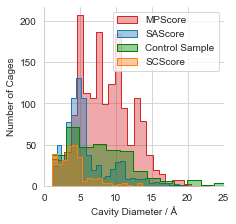

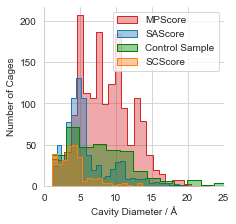

In [164]:
plot_figure_7()

In [165]:
df_combinations[df_combinations['rfmodel_fulldataset'] < df_combinations['rfmodel_fulldataset'].quantile(0.01)].drop_duplicates('bb')

KeyError: 'rfmodel_fulldataset'

In [194]:
df_combinations['sascore_combination'].quantile(0.01)

0.17783487854629404